In [1]:
%matplotlib inline
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.utils import resample

save = False

cm = 1/2.54  # centimeters in inches
sns.set_context('paper', rc={'font.size': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
                          'figure.titleweight': 'bold', 'axes.labelsize':10, 'axes.titlesize':12})


dir_path = os.path.abspath('')

output_path = dir_path + '/Figures/'

In [2]:
def obtainTargetLatency(predictionTimecourse, y_true, offset=250):
    target_idx = np.where(y_true==1)
    latency = np.zeros(len(y_true))

    for t in range(len(y_true)):
        tps = np.where(predictionTimecourse[target_idx[0][t], offset:, target_idx[1][t]] >= 0.5)[0]
        if len(tps) == 0:
            latency[t] = np.nan
        else:
            latency[t] = np.min(tps) + offset
    return latency


In [3]:
colors = sns.color_palette(sns.xkcd_palette([ "orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))
mechanisms = ['precision','inputGain', 'outputGain']

tracker = {}
for mechanism in mechanisms:
    tracker[mechanism] = joblib.load(
    dir_path + '/ModelEvaluation/Performance_' + mechanism + '.pkl')


filename = dir_path + '/ModelEvaluation/RTs_bootstrap.pkl'

num_draws =500
size_draws = len(tracker['inputGain']['y_test_single'])
np.random.seed(3)
idx = np.arange(size_draws)


RTs = pd.DataFrame(np.full((len(mechanisms) * 2 * size_draws,4), np.nan), columns=['Mechanism','Attention', 'Trial', 'RT'])

RTs['Attention'] = np.repeat(np.arange(2)[np.newaxis,:], len(mechanisms) * size_draws, axis=0).flatten()
RTs['Mechanism'] = np.repeat(np.arange(len(mechanisms))[np.newaxis,:],2 * size_draws, axis=1).flatten()
RTs['Trial'] = np.repeat(np.repeat(np.arange(size_draws)[:, np.newaxis],2).flatten()[np.newaxis,:], len(mechanisms),axis=0).flatten()

replace_map = {'Attention': {0: 'valid', 1: 'invalid'}, 'Mechanism': {0: mechanisms[0], 1: mechanisms[1], 2: mechanisms[2]}}
RTs.replace(replace_map, inplace=True)

onset = 100
time_steps = np.arange(0, 650)
target_idx = np.where(tracker['inputGain']['y_test_single'] == 1)
non_target_idx =  np.where(tracker['inputGain']['y_test_single'] == 0)
baseline = tracker['inputGain']['mf_0.45']['testSet']['predictions']


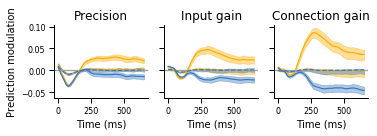

In [4]:

fig, ax = plt.subplots(1, 3, figsize=(13.5*cm, 5*cm), sharey=True, sharex=True)
ax = ax.flatten()

for m, mechanism in enumerate(mechanisms):
    for a, att in enumerate(['valid', 'invalid']):
        RTs.loc[(RTs['Mechanism'] == mechanism) & (RTs['Attention'] == att), 'RT'] = obtainTargetLatency(
            tracker[mechanism]['attention_0.45']['testSet'][att]['predictions'], tracker['inputGain']['y_test_single'],
            offset=tracker['inputGain']['start_eval'])

        modulation = tracker[mechanism]['attention_0.45']['testSet'][att]['predictions'][:, onset:, :] - baseline[:, onset:,
                                                                                         :]
        # bootstrap the 95%CI for every time point
        mean_draws_t = list()
        mean_draws_o = list()
        for d in range(num_draws):
            # Resampling, with replacement, taking the class imbalance into account
            draw = resample(idx, n_samples=size_draws, random_state=d, stratify=tracker['inputGain']['y_test_single'])
            mean_draws_t.append(np.mean(modulation[target_idx[0][draw], :, target_idx[1][draw]], axis=0))
            mean_draws_o.append(np.mean(modulation[non_target_idx[0][draw], :, non_target_idx[1][draw]], axis=0))

        ax[m].axhline(0, color=colors[2])

        ax[m].plot(time_steps, np.mean(modulation[target_idx[0], :, target_idx[1]], axis=0),
                   color=colors[a])
       
        ax[m].fill_between(time_steps, np.percentile(mean_draws_t, 2.5, axis=0),
                           np.percentile(mean_draws_t, 97.5, axis=0),
                           color=colors[a], alpha=0.4)

        ax[m].plot(time_steps, np.mean(modulation[non_target_idx[0], :, non_target_idx[1]], axis=0),
                   color=colors[a],
                   ls='--')
        ax[m].fill_between(time_steps, np.percentile(mean_draws_o, 2.5, axis=0),
                           np.percentile(mean_draws_o, 97.5, axis=0),
                           color=colors[a], alpha=0.4)

        sns.despine(ax=ax[m])
    ax[0].set_ylabel('Prediction modulation')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_title('Precision')
    ax[0].set_yticks([-0.05, 0, 0.05, 0.1])

    ax[1].set_title('Input gain')
    ax[1].set_xlabel('Time (ms)')

    ax[2].set_title('Connection gain')
    ax[2].set_xlabel('Time (ms)')


plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig(output_path + 'Modulation_allConditions.pdf', dpi=300, transparent=True)
else:
    plt.show()

In [6]:
if not os.path.isfile(filename):
    # Save the results
    RTs.to_pickle(filename)
    
neutral_Latencies = obtainTargetLatency(
            tracker['inputGain']['mf_0.45']['testSet']['predictions'], tracker['inputGain']['y_test_single'],
            offset=tracker['inputGain']['start_eval'])



517
481
511


475
525
460


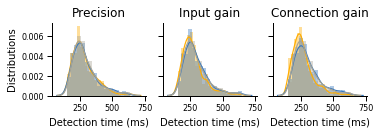

In [7]:
offset = 0
onset = 100

time_steps = np.arange(-onset, 750 - 100)

fig, ax = plt.subplots(1, 3, figsize=(13.5*cm, 5*cm), sharey=True, sharex=True)
ax = ax.flatten()

for m, mechanism in enumerate(mechanisms):
    for i, att in enumerate(['valid', 'invalid']):
        print(np.sum(RTs.loc[(RTs['Mechanism'] == mechanism) & (RTs['Attention'] == att), 'RT'] > 0))
        sns.distplot(RTs.loc[(RTs['Mechanism'] == mechanism) & (RTs['Attention'] == att), 'RT'] - 100, color=colors[i], ax=ax[m])
        sns.despine(ax=ax[m])
    sns.distplot(neutral_Latencies - 100, color=colors[2],
                 ax=ax[m])

ax[0].set_ylabel('Distributions')
ax[0].set_xlabel('Detection time (ms)')
ax[0].set_title('Precision')

ax[1].set_title('Input gain')
ax[1].set_xlabel('Detection time (ms)')

ax[2].set_title('Connection gain')
ax[2].set_xlabel('Detection time (ms)')


plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig(output_path + 'DetectionTimes_allConditions_neutral.pdf', dpi=300, transparent=True)
else:
    plt.show()

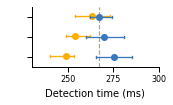

In [8]:
medians = RTs.groupby(['Mechanism', 'Attention'])['RT'].median() - 100

RTs['RT_onset'] = RTs['RT'] - onset

dodge = True
capsize = 0.1
aspect = 1.9
errwidth = 1.3

g = sns.catplot(y="Mechanism", x="RT_onset", hue="Attention", data=RTs,
                height=4 * cm, aspect=aspect, kind="point",
                palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                legend=False, estimator=np.median, zorder=6, order=mechanisms, join=False, dodge=dodge,
                capsize=capsize, errwidth=errwidth, orient='h')

g.set_yticklabels([' ', ' ', ' \n ', ' \n ', ' ',
                   ' \n ', '  \n '])

mean = np.nanmedian(neutral_Latencies) - onset

limits = np.array([230, 300])
plt.xlim(limits)
g.ax.set_xlabel('Detection time (ms)')
g.ax.set_ylabel(' ')
g.ax.set_xticks([250, 275, 300])

g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)

sns.despine(top=True, right=True)
if save == True:
    g.savefig(output_path + 'DetectionTimes_' + mode + '.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [ ]:
import random
conds = ['precision', 'inputGain', 'outputGain']
comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])
neutralRTs = obtainTargetLatency(
    tracker['inputGain']['mf_0.45']['testSet']['predictions'], tracker['inputGain']['y_test_single'],
    offset=tracker['inputGain']['start_eval'])

idx = np.arange(len(neutralRTs)*2)
# Define p (number of permutations):
p = 10000


results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for cond in conds:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validRTs = RTs.loc[(RTs['Mechanism'] == cond) & (RTs['Attention'] == 'valid'), 'RT']

    invalidRTs = RTs.loc[(RTs['Mechanism'] == cond) & (RTs['Attention'] == 'invalid'), 'RT']

    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.nanmedian(validRTs) - np.nanmedian(invalidRTs))
                samplePreds = np.concatenate([validRTs, invalidRTs], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.nanmedian(validRTs) - np.nanmedian(neutralRTs))

                samplePreds = np.concatenate([validRTs, neutralRTs], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.nanmedian(invalidRTs) - np.nanmedian(neutralRTs))
                samplePreds = np.concatenate([invalidRTs, neutralRTs], axis=0)

            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.nanmedian(samplePreds[idx[:int(len(idx)//2)]]) - np.nanmedian(samplePreds[idx[int(len(idx)//2):]])))


            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append(
                {'Mechanism': cond, 'Comparison': comp, 'Difference': diff, 'p-values': p_val,
                 'significant': p_val < results['alpha-level']}, ignore_index=True)

joblib.dump(results,
            dir_path + '/ModelEvaluation/RT_PermutationTestsComparisons.pkl',
            compress=True)
results_df.to_csv(dir_path + '/ModelEvaluation/RT_PermutationTestsComparisons_df.csv')
